<a href="https://colab.research.google.com/github/MasaAsami/ml-dae/blob/main/notebooks/dml_dea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [931]:
!pip install -q mapie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.1/178.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 27.7 MB/s eta 0:00:00


# 直交化DEA : 特定inputに着目した効率性分析
- 普通のDEA、効率性分析はDMUそのものの効率性を調査する
- しかし、中には特定のinput(補助金や特定の費用)に着目して、各ユニットにおける当該inputの効率的使用に関心が向けられるケースもあるだろう（関心inputと呼ぶ）
- このとき、DEAのフレームワークをそのまま適用することは危険である。関心inputは、その他のinputと相関がある可能性がある。例えば、資本金に応じて補助金が配られている場合など
- 因果推論のターミノロジーを使えば、交絡である
- 本研究ではDML、つまりアウトカムに対するモデルと関心inputに対するモデルを別途構築し、直交化したうえで効率性分析を行うことを提唱する
- 直交化した後の関心inputとoutputについては、通常の効率性分析(DEAやSFAなど)を用いても構わない


In [1503]:
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.style.use('ggplot')

import pandas as pd
import numpy as np
import numpy.random as rand


In [1469]:
def gen_corr_data(x, rho_in=0.6, seed=1):
    np.random.seed(seed)
    size = len(x)
    _x = np.random.randn(size)
    return rho_in * x + (1 - rho_in ** 2) ** 0.5 * _x

In [1470]:
SIZE = 1500
INPUT_DIM = 21
np.random.seed(0)
x = rand.randn(SIZE)
rho_list = np.random.uniform(-0.8, 0.3, INPUT_DIM -1)
df_list = []
df_list.append(x)
for i, _rho in enumerate(rho_list):
    df_list.append(
        gen_corr_data(x, rho_in=_rho, seed=i+1)
    )
df = pd.DataFrame(df_list).T
df.columns = ["input_{}".format(i) for i in range(INPUT_DIM)]
df = df.rename(columns={'input_0': 'target_input'})
df += 10
assert df.min().min() > 0

In [1471]:
np.random.seed(0)
beta1_list = np.random.uniform(0.2, 1.0, INPUT_DIM)
beta2_list = np.random.uniform(0., 1.5, INPUT_DIM)
beta1_list[0] = 2.5
beta2_list[0] = 2.5

In [1472]:
y1 = 10**(-15) * np.prod(df.values ** beta1_list, axis=1) * np.random.normal(1, 0.1, SIZE)
y2 = 10**(-16) * np.prod(df.values ** beta2_list, axis=1) * np.random.normal(1, 0.1, SIZE)
#y1 = df @ beta1_list + df['target_input']**0.2
#y2 = df @ beta2_list  + df['target_input']**0.2
df["output_1"] = y1
df["output_2"] = y2
assert df.min().min() > 0

In [1473]:
df = df.rename(columns={'input_0': 'target_input'})
other_input_cols = [_col for _col in df.columns if "input_" in _col]

In [1474]:
df.describe()

,target_input,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,...,input_13,input_14,input_15,input_16,input_17,input_18,input_19,input_20,output_1,output_2
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,9.979561,10.047687,9.966507,10.003252,10.035978,10.041116,10.012560,9.979542,10.046449,10.028248,...,10.002920,9.962699,9.985399,9.987655,10.036427,10.014023,9.991239,9.990012,13.699349,113.194864
std,0.980755,0.987202,0.992796,0.996005,0.972182,0.988486,0.974645,0.982431,1.019145,0.991738,...,0.996214,1.009236,0.998224,0.998681,1.016668,1.019146,0.987963,0.999761,4.593091,44.926572
min,6.953857,6.898738,6.565092,6.668537,7.064391,6.754893,6.728883,6.415655,6.434166,5.978444,...,6.790660,6.020686,6.548857,6.587114,5.778460,6.641422,6.657136,6.088648,2.891942,24.634366
25%,9.315789,9.375968,9.311546,9.363339,9.380515,9.371832,9.348465,9.335945,9.369767,9.373210,...,9.354771,9.296915,9.319216,9.331608,9.327741,9.321805,9.298398,9.296035,10.457941,81.318800
50%,9.971644,10.059659,9.945996,10.029408,10.026977,10.051510,10.001866,9.982886,10.047301,10.005994,...,10.024121,9.965138,9.990327,9.949699,10.058225,10.008650,10.007017,9.984117,13.060541,105.717444
75%,10.616566,10.711737,10.598720,10.666329,10.690186,10.708130,10.676332,10.669432,10.728176,10.684208,...,10.680974,10.660039,10.682406,10.639415,10.735912,10.691173,10.692141,10.671385,16.235801,137.593521
max,13.170975,13.532180,13.806422,14.501495,13.131326,13.588317,12.940501,13.079561,13.062780,14.085393,...,13.761825,13.457223,13.427575,13.906330,13.717259,14.068750,13.377319,12.995356,34.308744,336.037742


In [1476]:
from sklearn.model_selection import cross_val_predict
from lightgbm import LGBMRegressor
from sklearn.linear_model import LassoCV

In [1477]:
df_model = df.assign(
            input_res=df['target_input']
            - cross_val_predict(
                LassoCV(cv=5, random_state=0), df[other_input_cols], df['target_input'], cv=2
            ),
            output1_res=df['output_1']
            - cross_val_predict(
                LGBMRegressor(random_state=0), df[other_input_cols], df['output_1'], cv=2
            ),
            output2_res=df['output_2']
            - cross_val_predict(
                LGBMRegressor(random_state=0), df[other_input_cols], df['output_2'], cv=2
            ),
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5020
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 20
[LightGBM] [Info] Start training from score 13.838020
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [1478]:
res_cols = [col for col in df_model.columns if "res" in col]
df_model[res_cols].corr()

,input_res,output1_res,output2_res
input_res,1.000000,0.485524,0.457203
output1_res,0.485524,1.000000,0.528088
output2_res,0.457203,0.528088,1.000000


## 直交化処理後の関心inputとoutcome

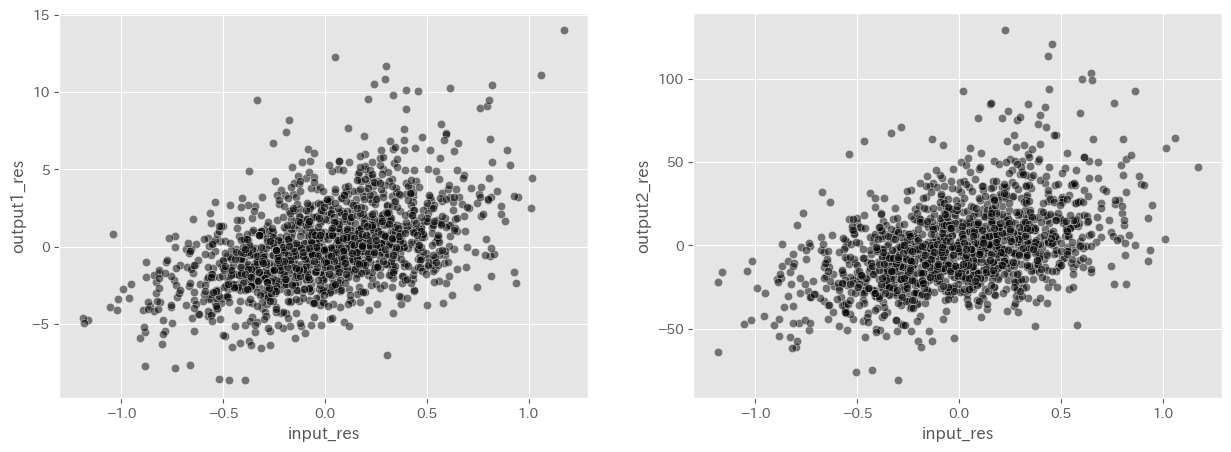

In [1479]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(
    data=df_model,
    x="input_res",
    y="output1_res",
    alpha = .5,
    ax=ax[0],
    color="black"
)
sns.scatterplot(
    data=df_model,
    x="input_res",
    y="output2_res",
    alpha = .5,
    ax=ax[1],
    color="black"
)

plt.show()

## 比較：関心inputとoutcomeの直接（ナイーブ）比較

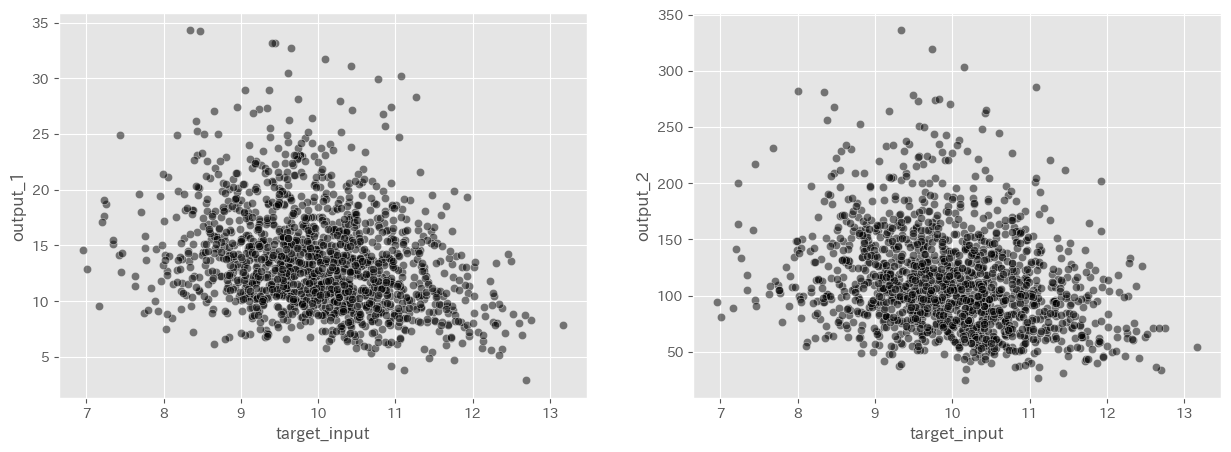

In [1480]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(
    data=df_model,
    x="target_input",
    y="output_1",
    alpha = .5,
    ax=ax[0],
    color="black"
)
sns.scatterplot(
    data=df_model,
    x="target_input",
    y="output_2",
    alpha = .5,
    ax=ax[1],
    color="black"
)

plt.show()

# confromal prediction as SFA
- 従来のSFAはモデルの仮定に頼りすぎている
- MLのconfromal predictionに閾値を決めて、それを効率フロンティアとしたほうがマシである
- ここでのDMU $i$ における効率性 $u_i$は以下の通りとする
$$
u_i = max( 0, \hat {y} ^{90tile}_i - y_i)
$$

In [1481]:
from sklearn.model_selection import train_test_split
from mapie.regression import MapieQuantileRegressor

In [1482]:
train_df, test_df = train_test_split(
    df_model, test_size=0.2, random_state=1
)

X_train, X_calib, y_train, y_calib = train_test_split(
    train_df[["input_res"]], train_df[["output1_res", "output2_res"]], test_size=0.1, random_state=1
)

In [1483]:
sfa_model1 = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
)
sfa_model2 = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
)

In [1484]:
%%time
mapie_model1 = MapieQuantileRegressor(
    sfa_model1,
    method='quantile',
    cv='split',
    alpha=0.1
)
mapie_model2 = MapieQuantileRegressor(
    sfa_model2,
    method='quantile',
    cv='split',
    alpha=0.1
)

mapie_model1.fit(
    X_train, y_train['output1_res'],
    X_calib = X_calib, y_calib = y_calib['output1_res'],
    random_state=0
)

mapie_model2.fit(
    X_train, y_train['output2_res'],
    X_calib = X_calib, y_calib = y_calib['output2_res'],
    random_state=0
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1080, number of used features: 1
[LightGBM] [Info] Start training from score -3.945687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1080, number of used features: 1
[LightGBM] [Info] Start training from score 4.858380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

MapieQuantileRegressor(cv='split',
                       estimator=LGBMRegressor(alpha=0.5, objective='quantile'))

In [1485]:
_, test_pred1 = mapie_model1.predict(test_df[["input_res"]])
_, test_pred2 = mapie_model2.predict(test_df[["input_res"]])

In [1486]:
test_df["pred_frontier1"] = test_pred1[:, 1, 0]
test_df["pred_frontier2"] = test_pred2[:, 1, 0]

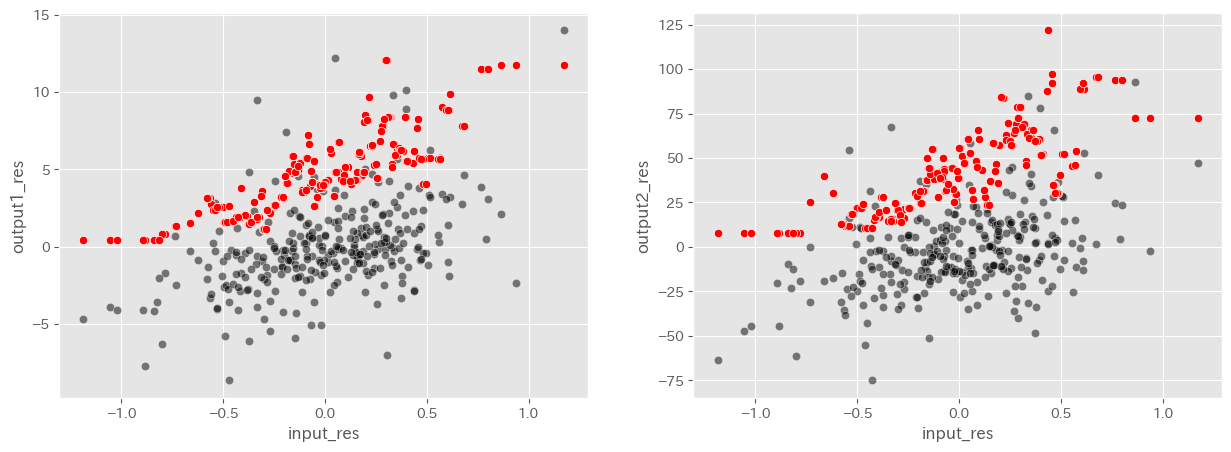

In [1487]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(
    data=test_df,
    x="input_res",
    y="output1_res",
    alpha =0.5,
    ax=ax[0],
    color="black"
)
sns.scatterplot(
    data=test_df,
    x="input_res",
    y="pred_frontier1",
    alpha = 1,
    ax=ax[0],
    color="red"
)

sns.scatterplot(
    data=test_df,
    x="input_res",
    y="output2_res",
    alpha =0.5,
    ax=ax[1],
    color="black"
)
sns.scatterplot(
    data=test_df,
    x="input_res",
    y="pred_frontier2",
    alpha = 1,
    ax=ax[1],
    color="red"
)

plt.show()

# DEA : 1 input vs. 2 output形式
- 直交化した後で、通常のDEAにかけることも可能

In [1488]:
def zscore(x,):
    xmean = x.mean()
    xstd  = x.std()
    zscore = (x-xmean)/xstd
    return zscore

dea_df = test_df[test_df.columns[-5:]].query("output1_res > 0 and output2_res > 0")
for _col in dea_df.columns:
    dea_df[_col] = zscore(dea_df[_col])
    dea_df[_col] += dea_df[_col].min()*-1 + 1

In [1489]:
dea_df['output1_res'] = np.where(dea_df['output1_res'] > dea_df['pred_frontier1'], dea_df['pred_frontier1'], dea_df['output1_res'])
dea_df['output2_res'] = np.where(dea_df['output2_res'] > dea_df['pred_frontier2'], dea_df['pred_frontier2'], dea_df['output2_res'])

In [1490]:
import numpy as np
from scipy.optimize import fmin_slsqp
from multiprocessing import Pool
from tqdm import tqdm

def optimize_one_unit(args):
    inputs, outputs, unit, m, r, n = args

    def target(x):
        in_w, out_w, lambdas = x[:m], x[m:m + r], x[m + r:]
        denominator = np.dot(inputs[unit], in_w)
        numerator = np.dot(outputs[unit], out_w)
        return numerator / denominator

    def constraints(x):
        in_w, out_w, lambdas = x[:m], x[m:m + r], x[m + r:]
        t = target(x)
        constr = []

        for i in range(m):
            lhs = np.dot(inputs[:, i], lambdas)
            constr.append(t * inputs[unit, i] - lhs)

        for o in range(r):
            lhs = np.dot(outputs[:, o], lambdas)
            constr.append(lhs - outputs[unit, o])

        for u in range(n):
            constr.append(lambdas[u])

        return np.array(constr)

    d0 = m + r + n
    x0 = np.random.rand(d0) - 0.5
    result = fmin_slsqp(target, x0, f_ieqcons=constraints, disp=False)
    in_w, out_w = result[:m], result[m:m + r]
    denominator = np.dot(inputs, in_w)
    numerator = np.dot(outputs, out_w)
    return (numerator / denominator)[unit]


class DEA(object):

    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

        self.n = inputs.shape[0]
        self.m = inputs.shape[1]
        self.r = outputs.shape[1]

        self.unit_ = range(self.n)
        self.input_ = range(self.m)
        self.output_ = range(self.r)

        self.output_w = np.zeros((self.r, 1), dtype=float)
        self.input_w = np.zeros((self.m, 1), dtype=float)
        self.lambdas = np.zeros((self.n, 1), dtype=float)
        self.efficiency = np.zeros_like(self.lambdas)

        self.names = []

    def __optimize(self):
        args = [(self.inputs, self.outputs, unit, self.m, self.r, self.n) for unit in self.unit_]
        with Pool() as pool:
            results = list(tqdm(pool.imap(optimize_one_unit, args), total=self.n, desc="Optimizing DEA"))
        self.efficiency = np.array(results).reshape(-1, 1)

    def name_units(self, names):
        assert self.n == len(names)
        self.names = names

    def fit(self):
        self.__optimize()


In [1491]:
dea = DEA(
    dea_df[["input_res"]].to_numpy(),
    dea_df[["output1_res", "output2_res"]].to_numpy()
)
dea.name_units(list(dea_df.index))
dea.fit()

Optimizing DEA: 100%|██████████| 77/77 [00:05<00:00, 13.52it/s]


In [1492]:
dea_df["dea_efficiency"] = dea.efficiency

In [1493]:
dea_df["retio_1"] = dea_df["output1_res"] / dea_df["input_res"]
dea_df["retio_2"] = dea_df["output2_res"] / dea_df["input_res"]

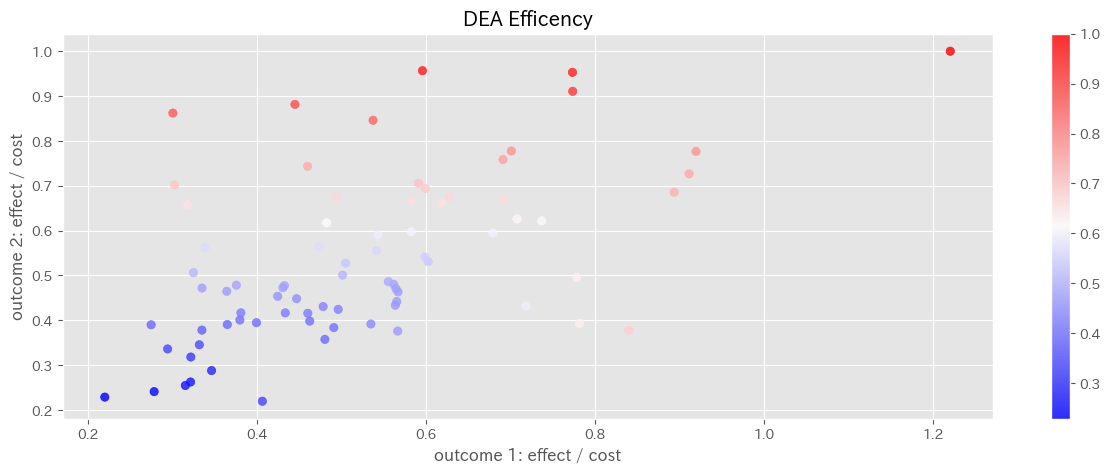

In [1513]:
fig = plt.figure(figsize=(15, 5))
plt.scatter(dea_df.retio_1, dea_df.retio_2, alpha = .8, c = dea_df.dea_efficiency, cmap = 'bwr')
cbar = plt.colorbar()
plt.title("DEA Efficency")
plt.xlabel("outcome 1: effect / cost")
plt.ylabel("outcome 2: effect / cost")
plt.grid(True)
plt.show()